In [1]:
 import numpy as np
 import cv2
 import os
 import random
 import matplotlib.pyplot as plt
 import PIL.Image as Image
 import pickle
 from sklearn.model_selection import train_test_split
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.models import Model
 from tensorflow.keras.utils import plot_model
 import tensorflow as tf
 from sklearn.metrics import classification_report,confusion_matrix

In [2]:
import tensorflow as tf
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras import layers 
import keras
from keras.layers import *
from keras import backend

In [3]:
DIRECTORY = r'/kaggle/input/brain-tumor-mri-dataset/Training'
CATEGORIES = ['glioma', 'meningioma', 'notumor','pituitary']
IMG_SIZE = 256
patch_size = 16   
expansion_factor = 2  
train_data = []

In [4]:
 for category in CATEGORIES:
     folder = os.path.join(DIRECTORY,category)
     #print(folder)
     label = CATEGORIES.index(category)
     for img in os.listdir(folder):
         img_path = os.path.join(folder, img)
         #print(img_path)
         img_arr = cv2.imread(img_path)
         img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
         #plt.imshow(img_arr)
         #break
         train_data.append([img_arr, label])

In [5]:
 len(train_data)

5712

In [6]:
 random.shuffle(train_data)

In [7]:
 X_train = []
 y_train = []
 for features, labels in train_data:
     X_train.append(features)
     y_train.append(labels)

In [8]:
DIRECTORY = r'/kaggle/input/brain-tumor-mri-dataset/Testing'
CATEGORIES = ['glioma', 'meningioma', 'notumor','pituitary']
IMG_SIZE = 256
patch_size = 16   
expansion_factor = 2  
test_data = []

In [9]:
 for category in CATEGORIES:
     folder = os.path.join(DIRECTORY,category)
     #print(folder)
     label = CATEGORIES.index(category)
     for img in os.listdir(folder):
         img_path = os.path.join(folder, img)
         #print(img_path)
         img_arr = cv2.imread(img_path)
         img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
         #plt.imshow(img_arr)
         #break
         test_data.append([img_arr, label])

In [10]:
 len(test_data)

1311

In [11]:
 X_test = []
 y_test = []
 for features, labels in test_data:
     X_test.append(features)
     y_test.append(labels)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
 X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5712, 256, 256, 3), (1311, 256, 256, 3), (5712,), (1311,))

In [14]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation=keras.activations.swish,
        padding="same",
    )
    return conv_layer(x)


# Reference: https://github.com/keras-team/keras/blob/e3858739d178fe16a0c77ce7fab88b0be6dbbdc7/keras/applications/imagenet_utils.py#L413C17-L435


def correct_pad(inputs, kernel_size):
    img_dim = 2 if backend.image_data_format() == "channels_first" else 1
    input_size = inputs.shape[img_dim : (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if keras.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m

In [15]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=0.1,
        )
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x

In [17]:
def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [18]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [19]:
model=create_mobilevit()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │            512 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu (Silu)               │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 128, 128, 32)   │            288 │ silu[0][0]             │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_1 (Silu)             │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 16)   │            512 │ silu_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │            512 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_2 (Silu)             │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 129, 129, 32)   │              0 │ silu_2[0][0]           │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 1,307,621 (4.99 MB)

 Trainable params: 1,305,077 (4.98 MB)

 Non-trainable params: 2,544 (9.94 KB)

In [20]:
class_weights = {0:1.1347,
                 1:0.9095,
                 2:0.9811}

In [21]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                                 loss='sparse_categorical_crossentropy',
                                                 metrics=['accuracy'])

In [23]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [24]:
 filepath = "/kaggle/working/My_model.keras"
 checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy",
                              verbose=1, save_best_only=True,
                              mode='max')
 reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1)
 callbacks = [checkpoint, reduce_lr] 

In [25]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [26]:
with tf.device('/GPU:0'):
             history= model.fit(X_train, y_train, 
                        validation_data=[X_test, y_test],
                        class_weight=class_weights,
                        callbacks=callbacks,
                        epochs=50,batch_size=32)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5729 - loss: 1.0434
Epoch 1: val_accuracy improved from -inf to 0.22883, saving model to /kaggle/working/My_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 674ms/step - accuracy: 0.5734 - loss: 1.0423 - val_accuracy: 0.2288 - val_loss: 1.6635 - learning_rate: 1.0000e-04
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7793 - loss: 0.6021
Epoch 2: val_accuracy did not improve from 0.22883
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.7794 - loss: 0.6019 - val_accuracy: 0.2288 - val_loss: 2.2684 - learning_rate: 1.0000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8188 - loss: 0.4865
Epoch 3: val_accuracy improved from 0.22883 to 0.43707, saving model to /kaggle/working/My_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.8188 - loss: 0.4864 - val_accuracy: 0.4371 - val_loss: 1.3644 - learning_rate: 1.0000e-04
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


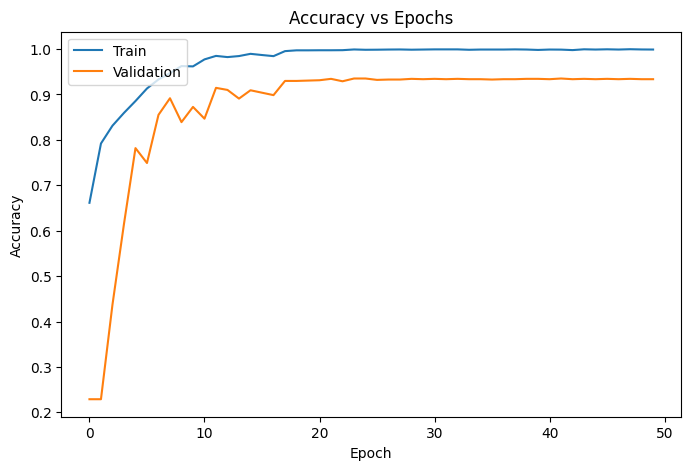

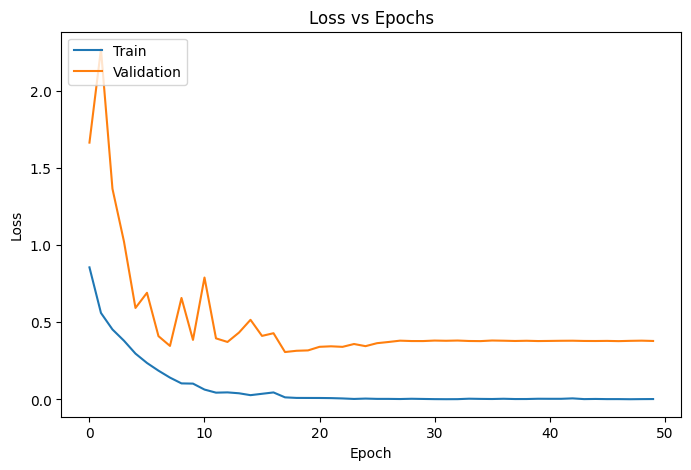

In [27]:
 print(history.history.keys())
 #  "Accuracy"
 plt.figure(figsize=(8, 5))
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('Accuracy vs Epochs')
 plt.ylabel('Accuracy')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()
 # "Loss"
 plt.figure(figsize=(8, 5))
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('Loss vs Epochs')
 plt.ylabel('Loss')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()

In [28]:
re_model = tf.keras.models.load_model('/kaggle/working/My_model.keras')

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8906 - loss: 0.6345
Test Accuracy: 0.9336


In [30]:
 y_pred = re_model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step


In [31]:
 y_true = y_test

In [32]:
 y_pred = np.argmax(y_pred, axis=1)
 y_pred

array([0, 1, 0, ..., 3, 3, 3])

In [33]:
 print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       300
           1       0.88      0.86      0.87       306
           2       0.99      1.00      0.99       405
           3       0.96      0.97      0.96       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.94      0.93      1311



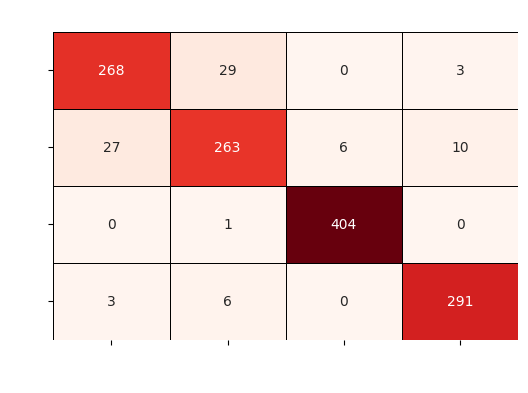

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap with red-black color scheme
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False, linewidths=0.5, linecolor='black')

# Set black background
plt.gca().set_facecolor('black')
plt.xlabel("Predicted", color="white")
plt.ylabel("Actual", color="white")
plt.title("Confusion Matrix", color="white")

# Change tick colors to white
plt.xticks(color="white")
plt.yticks(color="white")

plt.show()
